In [3]:
# import requests to install tesseract
import requests

In [5]:
# Download tesseract
r = requests.get("https://raw.githubusercontent.com/tesseract-ocr/tessdata/4.00/ind.traineddata", stream=True)

# Writing data to file to avoid path issues
with open("/usr/share/tesseract-ocr/4.00/tessdata/ind.traineddata", "wb") as file:
  for block in r.iter_content(chunk_size = 1024):
    if block:
      file.write(block)

In [6]:
# Install OCR Required Libraries
! apt install tesseract-ocr libtesseract-dev libmagickwand-dev

# Importing IPython to clear output which is not important
from IPython.display import HTML, clear_output
clear_output()

In [7]:
# Install pytesseract and opencv
! pip install pytesseract wand opencv-python
clear_output()

In [8]:
# Import necessary libraries
from PIL import Image
import pytesseract
import cv2
import numpy as np
from pytesseract import Output
import re

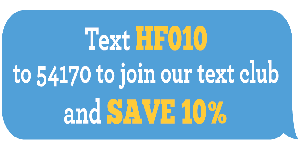

In [10]:
# Reading image from url
image = Image.open(requests.get("https://az721511.vo.msecnd.net/images/3c16ab5b-b839-4e2e-b8ee-61a4b456b1ba.png", stream=True).raw)
image = image.resize((300, 150))
image.save('sample.png')
image

In [13]:
# Extract the text
custom_config = r'-l eng --oem 3 --psm 6'
text = pytesseract.image_to_string(image, config=custom_config)
print(text)

Text HF010
ORT AW OLR uM aT Stat}
and SAVE 10%



In [19]:
# Remove irrelevant characters
try:
  text = pytesseract.image_to_string(image, lang="eng")
  characters_to_remove = "!()@-*>+-/{},|$#&^_~"
  new_string = text
  for character in characters_to_remove:
    new_string = new_string.replace(character, "")
  print(new_string)
except IOError as e:
  print("Error (%s)." % e)

Text HF010

ORT AW OLR uM aT Stat
and SAVE 10%

 



In [20]:
# Peroform opencv operations
image = cv2.imread('sample.png')

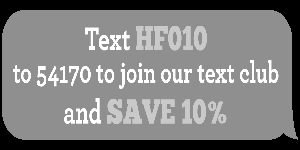

In [21]:
# get grayscale image
def get_grayscale(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = get_grayscale(image)
Image.fromarray(gray)

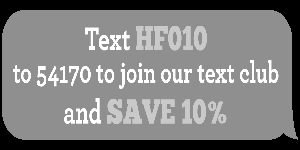

In [22]:
# Remove noise
def remove_noise(image):
  return cv2.medianBlur(image, 5)
noise = remove_noise(gray)
Image.fromarray(gray)

In [23]:
# Perform Threshold transformation
def thresholding(image):
  return cv2.threshold(image, 0, 255, cv2.TRESH_BINARY + cv2.THRESH_OTSU)[1]
  thresh = thresholding(gray)
  Image.fromarray(thresh)

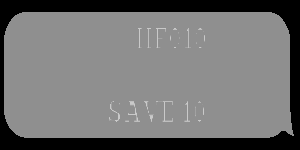

In [25]:
# erosion
def erode(image):
  kernel = np.ones((5,5),np.uint8)
  return cv2.erode(image, kernel, iterations=1)
erode = erode(gray)
Image.fromarray(erode)

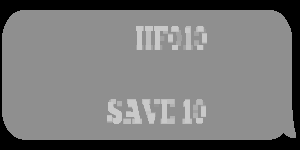

In [26]:
# Morphology
def opening(image):
  kernel = np.ones((5,5), np.uint8)
  return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
opening = opening(gray)
Image.fromarray(opening)

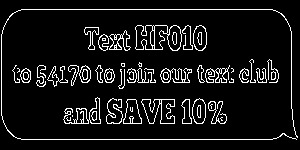

In [27]:
# Canny Edge Detection
def canny(image):
  return cv2.Canny(image, 100, 200)
canny = canny(gray)
Image.fromarray(canny)

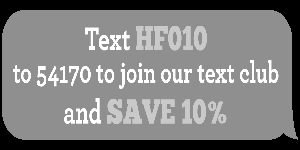

In [28]:
# Skew Correction
def deskew(image):
  coords = np.column_stack(np.where(image > 0))
  angle = cv2.minAreaRect(coords)[-1]
  if angle < -45:
    angle = -(90 + angle)
  else:
    angle = -angle
  (h, w) = image.shape[:2]
  center = (w // 2, h // 2)
  M = cv2.getRotationMatrix2D(center, angle, 1.0)
  rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
  return rotated
rotated = deskew(gray)
Image.fromarray(rotated)

In [30]:
# template matching
def match_template(image, template):
  return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
match = match_template(gray, gray)
match

array([[1.]], dtype=float32)

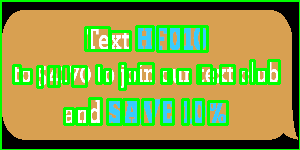

In [31]:
# Draw Rectangle around text
img = cv2.imread('sample.png')
h, w, c = img.shape
boxes = pytesseract.image_to_boxes(img)
for b in boxes.splitlines():
  b = b.split(' ')
  img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)
Image.fromarray(img)

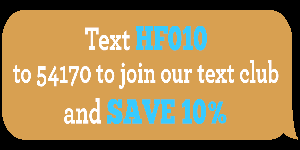

In [32]:
# Draw pattern on specific pattern or word
img = cv2.imread('sample.png')
d = pytesseract.image_to_data(img, output_type=Output.DICT)
keys = list(d.keys())

date_pattern = 'artificially'

n_boxes = len(d['text'])
for i in range(n_boxes):
  if int(d['conf'][i]) > 60:
    if re.match(date_pattern, d['text'][i]):
      (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
      img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
Image.fromarray(img)